In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path
import cv2
import math
from pyzbar.pyzbar import decode as pyzbar_decode

# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore')

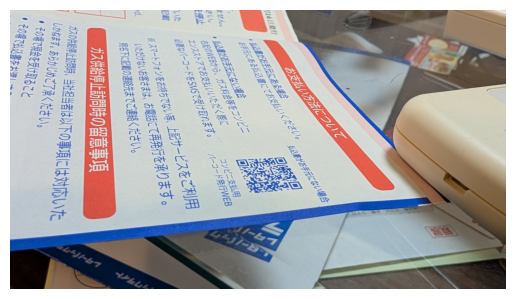

In [18]:
# image_path = Path("exmples/test_qr.png")
image_path = Path("exmples/2025-04-26 21.24.27.jpg")

img = cv2.imread(str(image_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# まずは表示
plt.axis('off')
plt.imshow(img)
plt.show()


In [21]:
qr_param = pyzbar_decode(img)

In [31]:
qr_code_polygon = qr_param[0].polygon
qr_code_polygon

[Point(x=1835, y=1219),
 Point(x=1954, y=1490),
 Point(x=2378, y=1451),
 Point(x=2226, y=1199)]

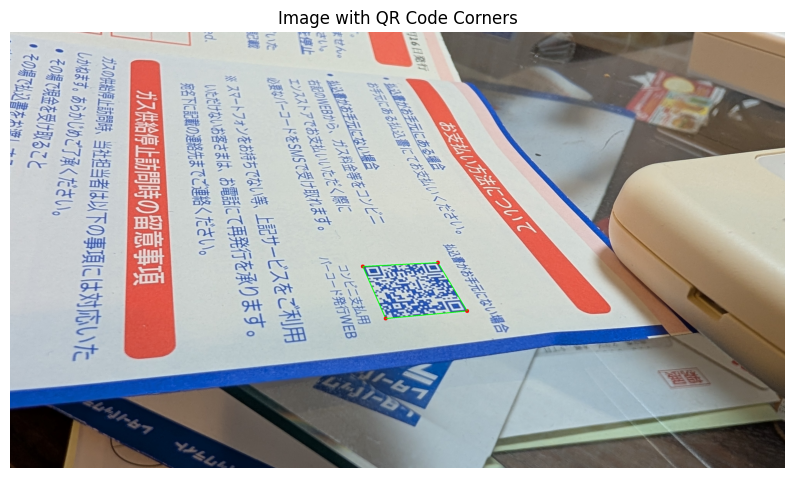

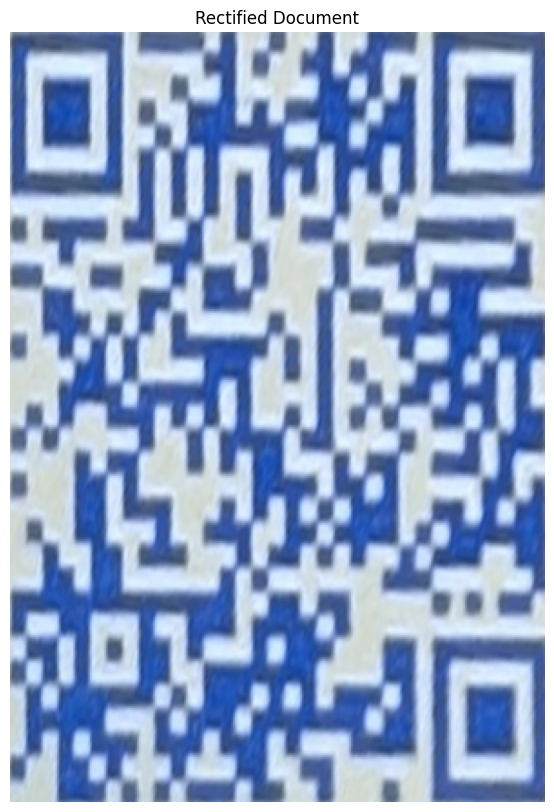

QR Code content: https://reception.tokyo-gas.co.jp/tgcbpay 


In [ ]:
# Convert QR code polygon points to numpy array
points = np.array([[p.x, p.y] for p in qr_code_polygon], dtype=np.float32)

# Create a copy of the original image to draw on
img_with_points = img.copy()

# Draw polygon points on the image for visualization
for i, point in enumerate(points):
    pt1 = (int(point[0]), int(point[1]))
    pt2 = (int(points[(i+1) % 4][0]), int(points[(i+1) % 4][1]))
    cv2.circle(img_with_points, pt1, 10, (255, 0, 0), -1)
    cv2.line(img_with_points, pt1, pt2, (0, 255, 0), 3)

# Display the image with QR code corners
plt.figure(figsize=(10, 8))
plt.imshow(img_with_points)
plt.axis('off')
plt.title('Image with QR Code Corners')
plt.show()

# Print QR code content
print("QR Code content:", qr_param[0].data.decode('utf-8'))

# 画像全体を透視変換して元に戻す

QRコードの形状から画像全体の歪みを修正します。

Average QR code side length: 351.89 pixels
QR code center: (2098.25, 1339.75)


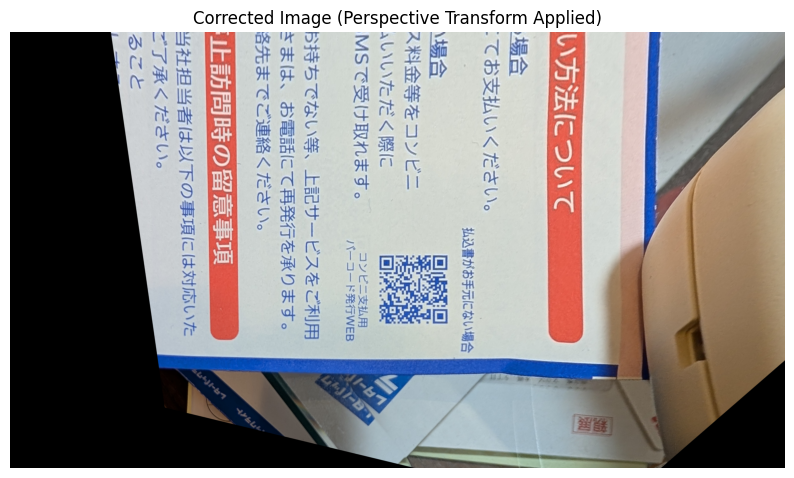

In [36]:
# Get image dimensions
original_height, original_width = img.shape[:2]

# Assuming the QR code should be a square in real world
# Calculate the average side length of the QR code
side_lengths = []
for i in range(4):
    p1 = points[i]
    p2 = points[(i+1) % 4]
    side_lengths.append(np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2)))

avg_side_length = np.mean(side_lengths)
print(f"Average QR code side length: {avg_side_length:.2f} pixels")

# Define what a perfect square QR code should look like at the same position
# We'll use the center of the detected QR code as reference
center_x = np.mean(points[:, 0])
center_y = np.mean(points[:, 1])
print(f"QR code center: ({center_x:.2f}, {center_y:.2f})")

# Create points for an ideal square QR code centered at the same position
half_side = avg_side_length / 2
ideal_qr_points = np.array([
    [center_x - half_side, center_y - half_side],  # top-left
    [center_x - half_side, center_y + half_side],  # bottom-left
    [center_x + half_side, center_y + half_side],  # bottom-right
    [center_x + half_side, center_y - half_side]   # top-right
], dtype=np.float32)

# Calculate the perspective transform matrix from detected points to ideal points
perspective_matrix = cv2.getPerspectiveTransform(points, ideal_qr_points)

# Apply perspective transformation to the entire image
corrected_img = cv2.warpPerspective(img, perspective_matrix, (original_width, original_height))

# Display the corrected image
plt.figure(figsize=(10, 8))
plt.imshow(corrected_img)
plt.axis('off')
plt.title('Corrected Image (Perspective Transform Applied)')
plt.show()

# クロップして最終画像を表示

余分な部分を切り取り、最終的な画像を表示します。

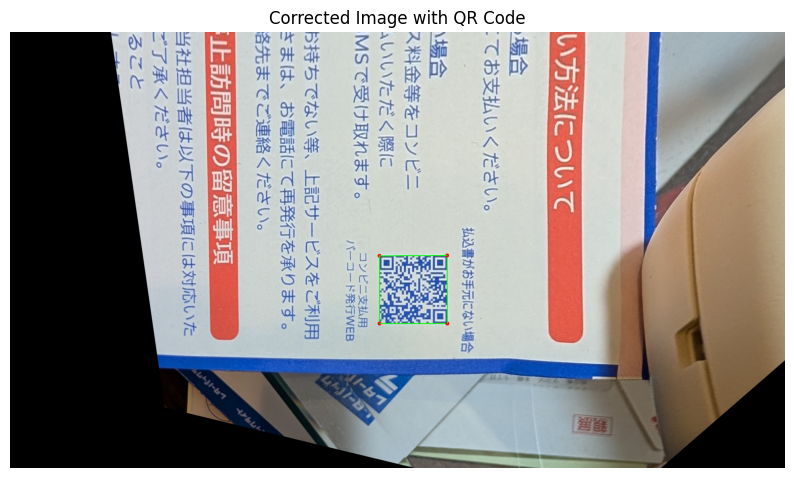

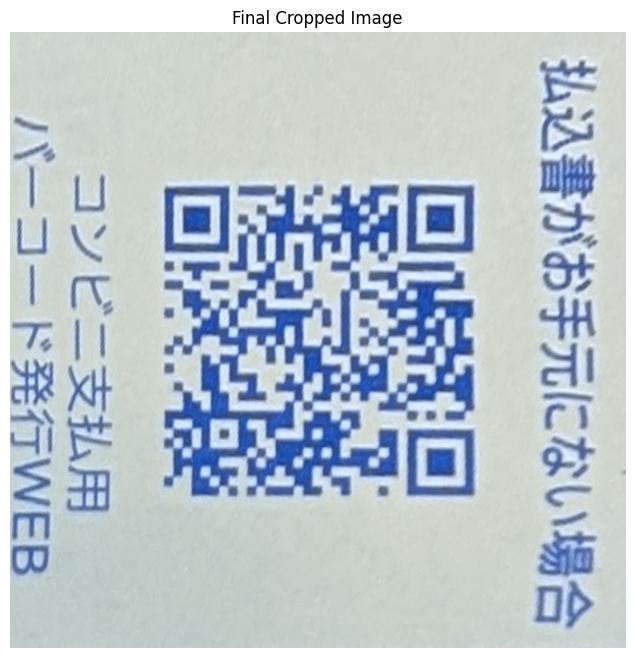

QR Code content in corrected image: https://reception.tokyo-gas.co.jp/tgcbpay 


In [37]:
# Find the QR code in the corrected image
corrected_qr_params = pyzbar_decode(corrected_img)

if corrected_qr_params:
    corrected_qr_polygon = corrected_qr_params[0].polygon
    corrected_points = np.array([[p.x, p.y] for p in corrected_qr_polygon], dtype=np.float32)
    
    # Display the corrected image with QR code highlighted
    corrected_with_points = corrected_img.copy()
    
    for i, point in enumerate(corrected_points):
        pt1 = (int(point[0]), int(point[1]))
        pt2 = (int(corrected_points[(i+1) % 4][0]), int(corrected_points[(i+1) % 4][1]))
        cv2.circle(corrected_with_points, pt1, 10, (255, 0, 0), -1)
        cv2.line(corrected_with_points, pt1, pt2, (0, 255, 0), 3)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corrected_with_points)
    plt.axis('off')
    plt.title('Corrected Image with QR Code')
    plt.show()
    
    # Create a cropped version with minimal padding around the QR code
    x_coords = corrected_points[:, 0]
    y_coords = corrected_points[:, 1]
    
    min_x = max(0, int(np.min(x_coords) - avg_side_length/2))
    min_y = max(0, int(np.min(y_coords) - avg_side_length/2))
    max_x = min(original_width, int(np.max(x_coords) + avg_side_length/2))
    max_y = min(original_height, int(np.max(y_coords) + avg_side_length/2))
    
    cropped_img = corrected_img[min_y:max_y, min_x:max_x]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_img)
    plt.axis('off')
    plt.title('Final Cropped Image')
    plt.show()
    
    print("QR Code content in corrected image:", corrected_qr_params[0].data.decode('utf-8'))
else:
    print("QR code not detected in the corrected image.")